### Import Dependencies:

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

conda install -c fastai fastai

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

# Collaborative Filtering Book Recommendation System Using Deep Learning with LLM Integration

## Collaborative Filtering Model

### Import and Process the Book Data:

### Import Data:

In [2]:
import pandas as pd
ratings = pd.read_csv('../Datasets/kaggle_book_recommendation/Ratings.csv')
books = pd.read_csv('../Datasets/kaggle_book_recommendation/Books.csv', dtype={3: 'str'})

### Process the Data:

Merge ratings dataframe with the books dataframe and remove unnecessary columns:

In [3]:
ratings_books_df = ratings.merge(books, on='ISBN')
ratings_books_df.drop(columns=['ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
ratings_books_df.columns = ['user', 'rating', 'title']
ratings_books_df.head()

,user,rating,title
0,276725,0,Flesh Tones: A Novel
1,276726,5,Rites of Passage
2,276727,0,The Notebook
3,276729,3,Help!: Level 1
4,276729,6,The Amsterdam Connection : Level 4 (Cambridge English Readers)


Filter the Data:

In [4]:
# Remove all ratings with 0.
ratings_books_df = ratings_books_df[ratings_books_df['rating'] > 0]

# Set thresholds for the number of ratings a user has given and the number of ratings a book has.
min_ratings_user = 100
min_ratings_book = 100

# Filters the dataframe to only include rows with users that have rated at least min_ratings_user books.
users_with_min_ratings = ratings_books_df.groupby('user').filter(lambda x: len(x) >= min_ratings_user)

# Filters the dataframe to only include movies with at least min_ratings_book ratings.
books_with_min_ratings = ratings_books_df.groupby('title').filter(lambda x: len(x) >= min_ratings_book)

# Filters the dataframe to include the correct data.
filtered_df = users_with_min_ratings[users_with_min_ratings['title'].isin(books_with_min_ratings['title'])]

filtered_df.head()

,user,rating,title
1168,277427,9,One for the Money (Stephanie Plum Novels (Paperback))
1215,277427,8,Me Talk Pretty One Day
1270,277427,9,The Rainmaker
1273,277427,9,Into the Wild
1276,277427,8,The Da Vinci Code


### Create a DataLoader Using the Data:

In [5]:
# Dataloaders - Set seed to 42 for consistent results
dls = CollabDataLoaders.from_df(filtered_df, item_name='title', rating_name='rating', bs=64, seed=42)
dls.show_batch()

,user,title,rating
0,94242,Ender's Game (Ender Wiggins Saga (Paperback)),10
1,13850,Fahrenheit 451,10
2,104636,Skipping Christmas,8
3,225763,Empire Falls,7
4,229741,The Catcher in the Rye,8
5,247447,The Rescue,10
6,266056,Digital Fortress : A Thriller,9
7,69078,Fahrenheit 451,9
8,219683,The Tao of Pooh,10
9,13552,Point of Origin,9


### Create a deep learning model with 2 hidden layers for collaborative filtering:

Create the model:

In [6]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 10.5), layers=[100,50])

Find the optimal learning rate:

SuggestedLRs(minimum=0.2754228591918945, steep=0.04786301031708717)

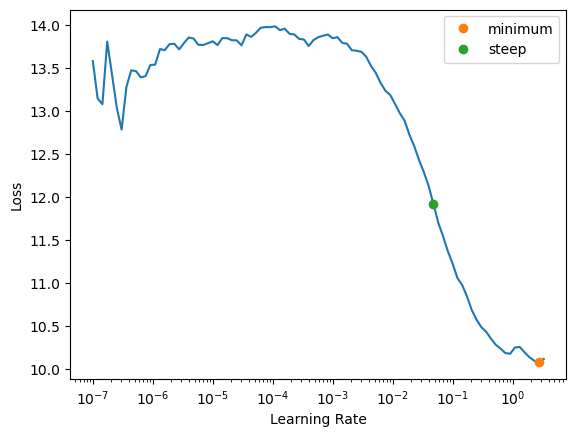

In [7]:
learn.lr_find(suggest_funcs=(minimum, steep))

Train the model:

In [8]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,10.194654,5.419633,00:00
1,4.533194,2.785439,00:00
2,2.730469,2.567227,00:00
3,1.823284,2.672868,00:00
4,1.246036,2.651535,00:00


### Predict user ratings for movies:

In [9]:
# User ID -- The user should already be in the training set or the new user
# should have initial rating values that are used to fine tune the model to include the user preferences for prediction
# Get a random user that exists in the training dataset.
user_id = filtered_df.sample(1)["user"].iloc[0]

# Creates a list of books that the user has not read.
rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
all_books = ratings_books_df['title'].unique().tolist()
unrated_books = [book for book in all_books if book not in rated_books]

# Creates a corresponding list of the user_id, the same size of the list.
users = [user_id] * len(unrated_books)

# Places the two lists into a dataframe.
df = pd.DataFrame({'user': users, 'title': unrated_books})

# Creates a test dataloader.
dl = learn.dls.test_dl(df)

# Gets the rating predictions of each unrated book.
preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

# Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
top_recommendations = [pred[0] for pred in sorted_preds[:10]]

print(f"Top 10 book recommendations for user {user_id}:")
for book in top_recommendations:
    print(book)

Top 10 book recommendations for user 93047:
Seabiscuit: An American Legend
The Red Tent (Bestselling Backlist)
Harry Potter and the Sorcerer's Stone (Book 1)
Ender's Game (Ender Wiggins Saga (Paperback))
Fahrenheit 451
The Secret Life of Bees
The Two Towers (The Lord of the Rings, Part 2)
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!
Two for the Dough
Angela's Ashes (MMP) : A Memoir


## 

## LLM Setup - Llama3-8B

#### Huggingface Authentication

In [10]:
from huggingface_hub import login
login()

#### Check GPU Status

In [11]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#### Install Transformers and accelerate

In [12]:
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

DEPRECATION: Loading egg at /home/saliu1/.conda/envs/CSE575/lib/python3.12/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-zehgkqcn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-zehgkqcn
  Resolved https://github.com/huggingface/transformers to commit 73014b561d5f88d728e46a57d346f516fefe3f2d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
DEPRECATION: Loading egg at /home/saliu1/.conda/envs/CSE575/lib/python3.12/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation

#### Load the Llama3 Model

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

#### Pass Initial Message to Test Model

In [14]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Arrrr, shiver me timbers! Me name be Captain Chat, the scurviest pirate chatbot to ever sail the Seven Seas! I be here to swab the decks o' yer mind with me witty banter and me treasure trove o' knowledge! So hoist the sails and set course fer a swashbucklin' good time, matey!


#

## LLM Recommendation Filtering

### Filtering Using the User's Liked Titles

#### Get the user's list of liked titles:

Return a dataframe containing all of the books the user has rated above the threshold:

In [22]:
user_id

93047

In [23]:
rating_threshold = 7
user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
user_liked_df

,user,rating,title
343323,93047,8,The Perfect Storm : A True Story of Men Against the Sea
343355,93047,7,"The Bad Beginning (A Series of Unfortunate Events, Book 1)"
343532,93047,7,Interview with the Vampire
343626,93047,7,Into the Wild
343699,93047,8,Harry Potter and the Chamber of Secrets (Book 2)
343701,93047,9,Harry Potter and the Prisoner of Azkaban (Book 3)
343702,93047,7,Harry Potter and the Goblet of Fire (Book 4)
343773,93047,7,The Handmaid's Tale
343906,93047,7,The Alienist
343944,93047,7,It


Get the list of book titles from the user_df:

In [24]:
liked_titles = user_liked_df["title"].tolist()
liked_titles

['The Perfect Storm : A True Story of Men Against the Sea',
 'The Bad Beginning (A Series of Unfortunate Events, Book 1)',
 'Interview with the Vampire',
 'Into the Wild',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 "The Handmaid's Tale",
 'The Alienist',
 'It',
 'Misery']

#### Get the List of Initial Recommendations

Get a list of the top 30 books returned by the Collaborative Filtering Model:

In [25]:
top_k = 30
initial_recommendations = [pred[0] for pred in sorted_preds[:top_k]]
initial_recommendations

['Seabiscuit: An American Legend',
 'The Red Tent (Bestselling Backlist)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 "Ender's Game (Ender Wiggins Saga (Paperback))",
 'Fahrenheit 451',
 'The Secret Life of Bees',
 'The Two Towers (The Lord of the Rings, Part 2)',
 'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!',
 'Two for the Dough',
 "Angela's Ashes (MMP) : A Memoir",
 'The Alchemist: A Fable About Following Your Dream',
 "Full House (Janet Evanovich's Full Series)",
 'A Painted House',
 'Night',
 'Sphere',
 'Cold Mountain : A Novel',
 'The Lost World',
 'To Kill a Mockingbird',
 "The Color of Water: A Black Man's Tribute to His White Mother",
 'The Hobbit : The Enchanting Prelude to The Lord of the Rings',
 'Angels &amp; Demons',
 "The Kitchen God's Wife",
 "White Oleander : A Novel (Oprah's Book Club)",
 'The Poisonwood Bible',
 'Digital Fortress : A Thriller',
 'Deception Point',
 'Bel Canto: A Novel',
 'The Queen of the Damned (Vampire Chronicl

#### Create the Prompt and Pass into the LLM for a Response

Create the Prompt:

In [30]:
message = {
    "role": "user",
    "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books: {liked_titles}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and provide a brief explanation for each recommendation."
}

messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
    },
    message
]

Pass into the Model and Print the Response:

In [31]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


After analyzing the user's liked books and the initial recommendations, I've refined the list to 10 books that match the user's preferences. Here are the recommendations:

1. **Seabiscuit: An American Legend**: Like "The Perfect Storm", this book is a non-fiction story about an underdog's journey to success, making it a great fit for the user's taste in inspiring true stories.
2. **The Two Towers (The Lord of the Rings, Part 2)**: As a fan of the Harry Potter series, the user may enjoy another epic fantasy series like The Lord of the Rings. This book is the second installment in the trilogy, which follows the journey of hobbits, elves, and humans in Middle-earth.
3. **Cold Mountain : A Novel**: The user may appreciate this historical fiction novel, which shares similarities with "Into the Wild" in its themes of adventure, survival, and self-discovery.
4. **The Alchemist: A Fable About Following Your Dream**: This book's themes of perseverance, spirituality, and following one's dreams m

# 

### Filtering Using the User's Liked Titles and Ratings for Each Title

In [32]:
user_liked_df

,user,rating,title
343323,93047,8,The Perfect Storm : A True Story of Men Against the Sea
343355,93047,7,"The Bad Beginning (A Series of Unfortunate Events, Book 1)"
343532,93047,7,Interview with the Vampire
343626,93047,7,Into the Wild
343699,93047,8,Harry Potter and the Chamber of Secrets (Book 2)
343701,93047,9,Harry Potter and the Prisoner of Azkaban (Book 3)
343702,93047,7,Harry Potter and the Goblet of Fire (Book 4)
343773,93047,7,The Handmaid's Tale
343906,93047,7,The Alienist
343944,93047,7,It


Create the list of books along with the user's ratings for eact title:

In [33]:
user_context = []
for _, row in user_liked_df.iterrows():
    user_context.append(f"{row["title"]} (Rating: {row["rating"]})")

In [34]:
user_context

['The Perfect Storm : A True Story of Men Against the Sea (Rating: 8)',
 'The Bad Beginning (A Series of Unfortunate Events, Book 1) (Rating: 7)',
 'Interview with the Vampire (Rating: 7)',
 'Into the Wild (Rating: 7)',
 'Harry Potter and the Chamber of Secrets (Book 2) (Rating: 8)',
 'Harry Potter and the Prisoner of Azkaban (Book 3) (Rating: 9)',
 'Harry Potter and the Goblet of Fire (Book 4) (Rating: 7)',
 "The Handmaid's Tale (Rating: 7)",
 'The Alienist (Rating: 7)',
 'It (Rating: 7)',
 'Misery (Rating: 8)']

Create the Message:

In [36]:
message = {
    "role": "user",
    "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_context)}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
}

messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
    },
    message
]

Pass into the LLM:

In [37]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Based on the user's liked books and ratings, I've refined the recommendations to a list of 10 books that match their preferences. Here's the list:

1. "The Two Towers (The Lord of the Rings, Part 2)" - This book is part of a popular fantasy series, similar to Harry Potter, and has a similar epic scope and adventure elements.
2. "Cold Mountain : A Novel" - The user enjoys historical fiction and adventure, and Cold Mountain is a historical novel with a strong narrative and vivid descriptions.
3. "The Alchemist: A Fable About Following Your Dream" - The user likes books with a strong narrative and adventure elements, and The Alchemist is a fable that explores themes of self-discovery and perseverance.
4. "The Poisonwood Bible" - The user enjoys literary fiction and complex characters, and The Poisonwood Bible is a critically acclaimed novel that explores themes of family, culture, and identity.
5. "Bel Canto: A Novel" - The user likes books with a strong narrative and complex characters, 